# Project Title : Food101 Image Clasification using Vision Transformers
# Author : Omar Mahmoud Abdel Rahman
# Date : 29/8/2024

In [37]:
# import needed dependencies
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder


from pathlib import Path
import os
import pathlib


import matplotlib.pyplot as plt
import PIL

import numpy as np

from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict
import random

from helper_functions import train, accuracy_fn


device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

In [2]:
train_data_dir = './Data/train'
test_data_dir = './Data/test'
train_data_path = Path(train_data_dir)
test_data_path = Path(test_data_dir)

def get_class_names(data_path):
    class_names = sorted(entry.name for entry in list(os.scandir(data_path)) if entry.is_dir())
    class_to_idx = {}
    for i in range(len(class_names)):
        class_to_idx[class_names[i]] = i
    return class_names, class_to_idx


class_names, class_to_idx = get_class_names(train_data_path)

In [16]:
# getting the pretrained model weights
pretrained_Vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# getting the model architic
pretrained_vit_model = torchvision.models.vit_b_16(weights = pretrained_Vit_weights).to(device)

# freezing all the layers, and we will just train the head of the model
for parameter in pretrained_vit_model.parameters():
    parameter.requires_grad = False

emb_size = 768
pretrained_vit_model.heads = nn.Linear(in_features = emb_size,
                                       out_features = len(class_names)).to(device)


In [17]:
from torchinfo import summary
BATCH_SIZE = 32
WIDTH = 224
HIEGHT = 224
NUM_CHANNELS = 3

summary(pretrained_vit_model,
        input_size = (BATCH_SIZE, NUM_CHANNELS, WIDTH, HIEGHT),
        col_names=['input_size', 'output_size', 'num_params','trainable'],
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]         [32, 3]                   768                       Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]         [32, 768, 14, 14]         (590,592)                 False
├─Encoder (encoder)                                          [32, 197, 768]            [32, 197, 768]            151,296                   False
│    └─Dropout (dropout)                                     [32, 197, 768]            [32, 197, 768]            --                        --
│    └─Sequential (layers)                                   [32, 197, 768]            [32, 197, 768]            --                        False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]            [32, 197, 768]            (7,087,872)   

In [8]:
train_transform = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.ToTensor()
])

In [9]:
train_dataset = ImageFolder(train_data_path,
                            transform= train_transform,
                            target_transform = None)

test_dataset = ImageFolder(test_data_path,
                           transform= test_transform,
                           target_transform=None)

In [10]:
train_dataloader = DataLoader(train_dataset,
                              batch_size = 32,
                              shuffle=True)

test_dataloader = DataLoader(test_dataset,
                             batch_size = 32,
                             shuffle = False)

train_data_sample, train_label_sample = next(iter(train_dataloader))

train_data_sample.shape, train_label_sample.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [18]:
optimzer = torch.optim.Adam(params = pretrained_vit_model.parameters(), lr = 0.1)
loss_fnc = nn.CrossEntropyLoss()

results = train(pretrained_vit_model,
      train_dataloader,
      test_dataloader,
      optimzer,
      loss_fnc,
      accuracy_fn,
      seed = 42,
      device = device,
      epochs = 11,
      early_stop=True,
      patience = 3,
      min_delta = 0.5)

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 0
 --------
Train Loss : 2.8606 | Train Accuravy : 81.25
Test Loss : 0.4214 | Test Accuracy : 97.50
Epoch: 1
 --------
Train Loss : 0.8307 | Train Accuravy : 93.75
Test Loss : 0.6898 | Test Accuracy : 95.62
Epoch: 2
 --------
Train Loss : 0.3052 | Train Accuravy : 96.88
Test Loss : 0.7069 | Test Accuracy : 94.72
Epoch: 3
 --------
Train Loss : 0.2229 | Train Accuravy : 97.08
Test Loss : 0.8448 | Test Accuracy : 93.52
Epoch: 4
 --------
Train Loss : 0.0383 | Train Accuravy : 99.58
Test Loss : 0.4244 | Test Accuracy : 97.50
Epoch: 5
 --------
Train Loss : 0.0386 | Train Accuravy : 99.38
Test Loss : 0.7328 | Test Accuracy : 94.43
Epoch: 6
 --------
Train Loss : 0.0556 | Train Accuravy : 98.96
Test Loss : 0.4415 | Test Accuracy : 96.88
Epoch: 7
 --------
Train Loss : 0.0014 | Train Accuravy : 100.00
Test Loss : 0.3433 | Test Accuracy : 96.88
Epoch: 8
 --------
Train Loss : 0.0066 | Train Accuravy : 99.58
Test Loss : 0.4791 | Test Accuracy : 96.88
Epoch: 9
 --------
Train Loss : 0.00

In [19]:
def plot_loss_curves(epochs : int,
                     train_loss : np.array,
                     test_loss : np.array,
                     train_acc : np.array,
                     test_acc : np.array):
    """Function used to plot the train and test losses and accuracies through epochs"""
    plt.figure(figsize = (10,6))
    epochs = np.array(range(epochs))
    # Plotting the train and test lossed 
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label = 'train loss')
    plt.plot(epochs, test_loss, label = 'test loss')
    plt.axis(True)
    plt.title(f"Train and Loss Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Train Test Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label = 'train acc')
    plt.plot(epochs, test_acc, label = 'test acc')
    plt.axis(True);
    plt.xlabel("Epochs")
    plt.ylabel("Train Test Accuracy")
    plt.title(f"Train and Test Accuracy Curves")
    plt.legend()
    plt.show();

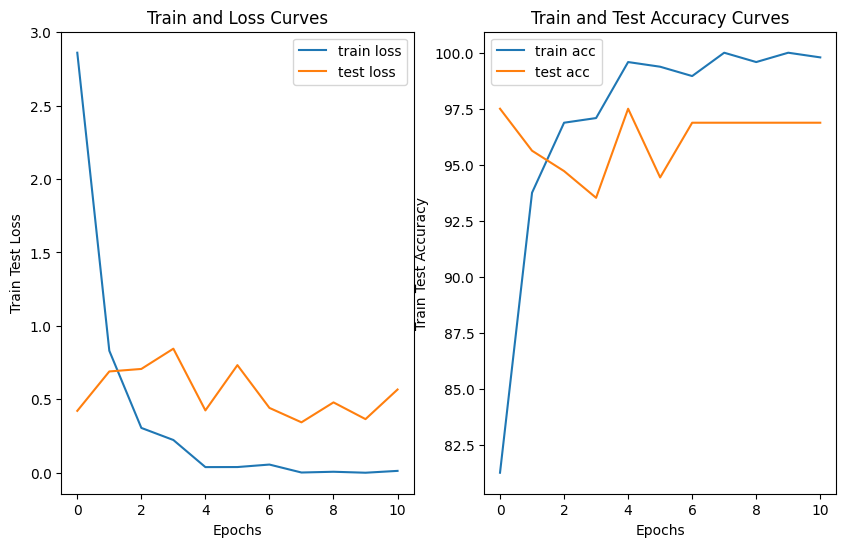

In [20]:
train_loss, test_loss = np.array(results['train_loss_epoch']), np.array(results['test_loss_epoch'])
train_acc , test_acc  = np.array(results['train_acc_epoch']), np.array(results['test_acc_epoch'])
epochs = len(train_loss)
plot_loss_curves(epochs, train_loss, test_loss, train_acc, test_acc) 

In [41]:
# Pipeline for infernce Mode "Predicting on custome images"

def Predict_Custom_Images(model:torch.nn.Module,
                          image_path : str,
                          device : torch.device = None):
    
    """Function taking image path as a string and a model and returns model_prediction and confedence level"""
    transform = transforms.Compose([
        transforms.Resize(size = (224, 224), antialias=True),
        # transforms.ToTensor()
    ])
    
    # reading an image using its path
    img = torchvision.io.read_image(image_path).type(torch.float32) / 255
    # Transforming our image into the right requirnments for our model
    img = transform(img)
    img = img.to(device)
 
    try :
        model.to(device)
    except :
        print(f"you are not specifing and device and you are now working on the cpu")
        model.to('cpu')
 
 
    # Making our model into the inference_mode so our grades does not change
    model.eval()
    with torch.inference_mode():
        # Calculating the raw logits 
        raw_logits = model(img.unsqueeze(0))

    # Converting the raw logits into prediction probabilities and then into prediction labels
    prediction_probability = torch.softmax(raw_logits, dim = 1).max().item()
    prediction_label = torch.softmax(raw_logits, dim = 1).argmax(dim = 1).item()
    print(f"ground Truth label is : {image_path.parts[-2]}")
    print(f"prediction label : {class_names[prediction_label]}\nConfidence : {(prediction_probability * 100):.2f}%")

    return prediction_label, prediction_probability

In [52]:
random_images_paths = [random.choices(list(pathlib.Path(test_data_dir).glob('*/*.jpg')), k = 10)]

random_images = random_images_paths[0]

In [53]:
for i, image_path in enumerate(random_images):
    print(f"this is iteration : {i} and the image path is: {str(image_path)}")
    prediction_label, prediction_probabilty = Predict_Custom_Images(model = pretrained_vit_model,
                                         image_path = image_path,
                                         device = device)

this is iteration : 0 and the image path is: Data\test\steak\3479599.jpg
ground Truth label is : steak
prediction label : sushi
Confidence : 100.00%
this is iteration : 1 and the image path is: Data\test\sushi\593071.jpg
ground Truth label is : sushi
prediction label : sushi
Confidence : 100.00%
this is iteration : 2 and the image path is: Data\test\steak\3100563.jpg
ground Truth label is : steak
prediction label : steak
Confidence : 100.00%
this is iteration : 3 and the image path is: Data\test\pizza\2901001.jpg
ground Truth label is : pizza
prediction label : pizza
Confidence : 100.00%
this is iteration : 4 and the image path is: Data\test\sushi\911808.jpg
ground Truth label is : sushi
prediction label : sushi
Confidence : 100.00%
this is iteration : 5 and the image path is: Data\test\pizza\380739.jpg
ground Truth label is : pizza
prediction label : pizza
Confidence : 100.00%
this is iteration : 6 and the image path is: Data\test\pizza\3376617.jpg
ground Truth label is : pizza
predic

In [54]:
from pathlib import Path
# creating the model directory 

Model_path = Path("models")
Model_path.mkdir(parents=True, exist_ok= True)
# create model save path 
MODEL_NAME = "fine_tuning_Vit.pth"
MODEL_SAVE_PATH = Model_path / MODEL_NAME
# saving model 
print(f"saving model to : {MODEL_SAVE_PATH} ")
torch.save(pretrained_vit_model.state_dict(), MODEL_SAVE_PATH)

saving model to : models\fine_tuning_Vit.pth 
